In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_mse, plot_sigma_squared, calculate_p_hat, plot_image

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


Simulated 20000 images of 100×100 = 10000 pixels true_sigma2=0.0


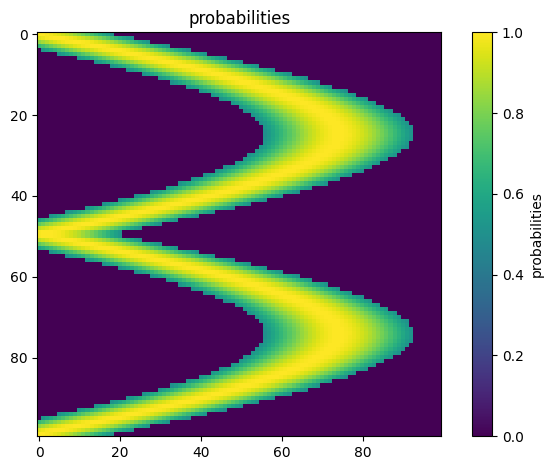

In [2]:
# Step 2: Generate synthetic data
# simulate a batch of images
in_feature = 100
r2 = 1.0                  # signal-to-noise ratio
n = 20000                  # number of images/samples
grids, true_beta, img, Y, true_sigma2 = simulate_data(n=n, r2=r2, dim=in_feature, random_seed=42)
# torch tensors

# pick one of your simulated images
print(f"Simulated {n} images of {in_feature}×{in_feature} = {img.shape[1]} pixels true_sigma2={true_sigma2}")
plot_image(true_beta)

In [3]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers =[8, 1],
    nu_tilde=2.5,
    b_for_eigen=20.0
)

In [4]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=0.0000005,
    num_epochs=600,  # fix this back to 300 later
    burn_in_epochs=0,
    batch_size=2000,
    model=model
)

In [5]:
# indices = torch.randperm(X.size(0))
# X, y = X[indices], y[indices]
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

X = torch.from_numpy(img).float().to('cpu')    # X.shape= (number of rows, total number of vexels)
y = torch.from_numpy(Y).float().to('cpu')      # y.shape= (number of rows,)
trainer.train(X, y)

Epoch 1/600
time elapsed 0.00014495849609375 seconds
Epoch 101/600
time elapsed 282.5336730480194 seconds
Epoch 201/600
time elapsed 570.9297540187836 seconds
Epoch 301/600
time elapsed 882.2961721420288 seconds
Epoch 401/600
time elapsed 1212.8620328903198 seconds
Epoch 501/600
time elapsed 1545.6391251087189 seconds


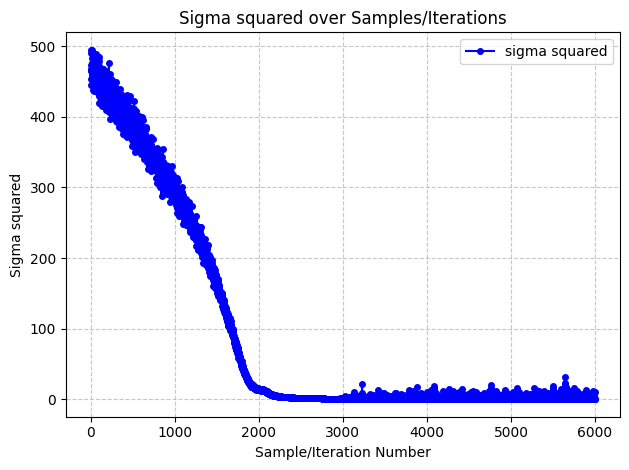

In [6]:
plot_sigma_squared(trainer)

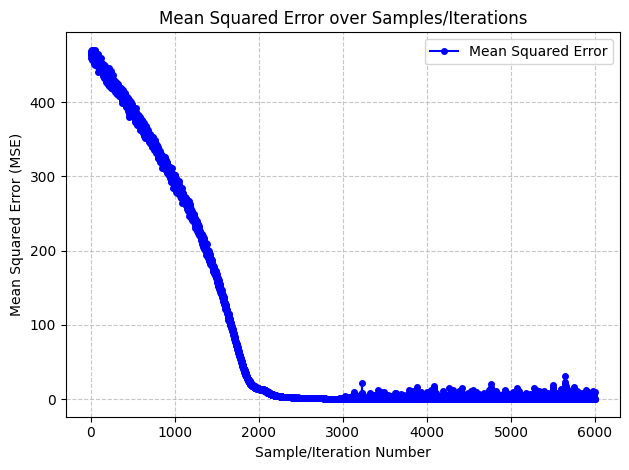

In [60]:
plot_mse(trainer)

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 1865


In [9]:
idx = 2
inputs = X[idx : idx+1]       # shape [1, V]
expected_y = Y[idx]
print(f"Y(predicted)={trainer.predict(inputs, -1000, -1)} Y(expected)={expected_y}")

predict (sample_avg)::variance_prediction=[[1.6154261]]
Y(predicted)=tensor([[22.5546]]) Y(expected)=22.68764298429399


In [44]:
beta_samples = trainer.samples['beta'][-1000: -1]

In [45]:
p_hat = calculate_p_hat(beta_samples)

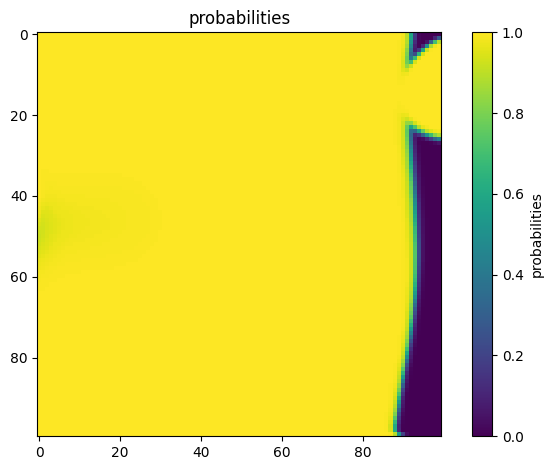

In [46]:
plot_image(p_hat)